# Effects of endorsement from Trump / Biden for Republican / Democratic Candidates
# Predict primary election outcomes 2022

Note: This project uses Pymc instead of Pymc3, as it works better on DeepNote

### Installation instruction for PyMC
Please install PyMC, our group has a hard time to get PyMC3 working on the local and deepnote. Currently we use version 5.3.0
https://www.pymc.io/projects/docs/en/latest/installation.html

Wiki info: https://en.wikipedia.org/wiki/PyMC

##### Note for staff:
If you don't use conda python packages management, you could use `pip` or `conda` by running below command. We only tested it via deepnote. We use arviz for some visualization, but arviz does not work on Deepnote becaseu of versioning reason (but work well on our end), so if the staff intend to test on deepnote, please remove arviz and all the function call to azviz.
 - pip install pymc
 - conda install -c conda-forge pymc


Our motivation stems from the belief that true learning occurs when we challenge ourselves to apply fundamental concepts beyond the scope of the classroom. Although our class teaches PyMC3, we aim to push ourselves by answering research questions using the latest version of PyMC. We recognize that while copying code from labs and demos may be tempting, the ultimate goal is to grasp the underlying concepts and develop the skills to apply them creatively in real-world scenarios.

In [1]:
#!pip install pymc

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import difflib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import arviz as az
from sklearn.linear_model import LogisticRegression
import pymc as pm
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

/root/venv/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/root/venv/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
def rmse(y_predict, y_true):
    """
    Calculate and return root mean square error
    """
    return np.mean((y_predict - y_true) ** 2) ** 0.5

def sigmoid(x):
    """
    Calculate sigmoid value
    """
    return 1 / (1 + math.exp(-x))
sigmoid = np.vectorize(sigmoid)

def print_confusion_matrix(y_true, y_pred):
    """
    Calculate true positives, true negatives, false negative, false positive. ALSO, print out for checking
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print('True positive', tp)
    print('True negative', tn)
    print('False negative', fn)
    print('False positive', fp)
    return tp, tn, fn, fp


def convert_to_number_of_endorsement(df, endorser_name, outcome):
    endorsement_df = df[~df[endorser_name].isna()][[endorser_name, outcome]]
    endorsement_df = endorsement_df[endorsement_df[outcome] != 'Made runoff']
    endorsement_df = endorsement_df.value_counts().reset_index()
    endorsement_total = endorsement_df.groupby(by=endorser_name).sum()
    endorsement_df = pd.merge(left=endorsement_df, right=endorsement_total, left_on=endorser_name, right_on=endorser_name);
    endorsement_df = endorsement_df.rename({'0_x': 'Count', '0_y': 'Total Count'}, axis=1)
    return endorsement_df

def create_mix_race(race1: str, race2: str, race3: str) -> str:
    """
    Combine three columns race 1,2,3 into one.
    """
    regex = r'\(.*\)'
    r1 = re.sub(regex, '', race1)
    r2 = re.sub(regex, '', race2)
    r3 = re.sub(regex, '', race3)
    
    race = sorted(list([r1.strip(), r2.strip(), r3.strip()]))
    return ' '.join(race).strip()

def get_lastname_firstname_from_endorsement_data(row):
    """
    Get last name and first name from endorsement data
    """
    fullname = row['Candidate'].split(' ')
    firstname = fullname[0]
    lastname = fullname[-1]
    return lastname.strip().upper(), firstname.strip().upper()

def get_lastname_firstname_from_finance(row):
    """
    Get Last name and first name from finance data
    """
    try:
        fullname = re.split(r',\s|\s', row['CAND_NAME'])
        lastname = fullname[0]
        firstname = fullname[1]
    except:
        print(row['CAND_NAME'])
    return lastname.strip().upper(), firstname.strip().upper()

def get_fuzzy_match(str1, series):
    """
    Get the last fuzzy match.
    """
    matches = difflib.get_close_matches(str1, series, n=2)
    if len(matches) > 0:
        return matches[0]
    return pd.NA

def set_biden_gang(row):
    """
    Combine endorsement from 'biden_aoc_sanders' list into Biden columns
    """
    biden_aoc_sanders = ['Sanders', 'AOC', 'Biden', 'Justice Dems', 'Our Revolution', 'Indivisible']
    for feat in biden_aoc_sanders:
        if row[feat] == 'Yes':
            return True
    return False

def get_finance_from(trump_df, finance_df):
    """
    Match data from endorsement to finance data
    """
    ret = pd.DataFrame()
    for _, row in trump_df.iterrows():
        ln = row['Lastname']
        fn = row['Firstname']
        matched = finance_df[finance_df['Lastname'].str.contains(ln) & finance_df['Firstname'].str.contains(fn)]
        matched['Race'] = row['Race']
        ret = pd.concat([ret, matched])
    return ret

def convert_to_number_of_endorsement(df, endorser_name, outcome):
    endorsement_df = df[~df[endorser_name].isna()][[endorser_name, outcome]]
    endorsement_df = endorsement_df[endorsement_df[outcome] != 'Made runoff']
    endorsement_df = endorsement_df.value_counts().reset_index()
    endorsement_total = endorsement_df.groupby(by=endorser_name).sum()
    endorsement_df = pd.merge(left=endorsement_df, right=endorsement_total, left_on=endorser_name, right_on=endorser_name);
    endorsement_df = endorsement_df.rename({'0_x': 'Count', '0_y': 'Total Count'}, axis=1)
    return endorsement_df

def preprocess_data(df):
    """
    Preporcess data endorsement_finance
    """
    df = df[df['Primary Outcome'] != 'Made runoff'].copy() # drop runoff data
    
    # Binarize variables
    df['Primary Outcome'].replace(to_replace='Won', value=1, inplace=True)
    df['Primary Outcome'].replace(to_replace='Lost', value=0, inplace=True)
    df['Primary Outcome'] = pd.to_numeric(df['Primary Outcome'])

    df['Incumbent Challenger'].replace(to_replace='Yes', value=1, inplace=True)
    df['Incumbent Challenger'].replace(to_replace='No', value=0, inplace=True)
    df['Incumbent'].replace(to_replace='Yes', value=1, inplace=True)
    df['Incumbent'].replace(to_replace='No', value=0, inplace=True)

    # Convert funding to numeric and take log
    df['TTL_RECEIPTS'] = pd.to_numeric(df['TTL_RECEIPTS'])
    df['TTL_INDIV_CONTRIB'] = pd.to_numeric(df['TTL_INDIV_CONTRIB'])
    df = df[df['TTL_INDIV_CONTRIB'] >= 0]
    df = df[df['TTL_RECEIPTS'] >= 0]
    df['TTL_RECEIPTS'] = np.log1p(df['TTL_RECEIPTS'])
    df['TTL_INDIV_CONTRIB'] = np.log1p(df['TTL_INDIV_CONTRIB'])
    
    return df

def find_optimal_threshold(trace, X_cols, Y_col):
    """
    Find optimal threshold. It is really long so we don't use it.
    """
    thresholds = np.linspace(0, 1, num=101)  # Create a range of thresholds from 0 to 1
    accuracies = []  # List to store the accuracies for each threshold

    # Iterate over the thresholds
    for threshold in thresholds:
        coeffs = list(trace.posterior[X_cols].mean()[X_cols].values())
        coeffs = [coeffs[i].values.item() for i in range(len(X_cols))]
        y_pre_proba = sigmoid(np.dot(test[X_cols], coeffs) + trace.posterior['intercept'].mean().values.item(0))
        y_pre_beyesian_decision = (y_pre_proba > threshold).astype(int)
        tp, tn, fp, fn = print_confusion_matrix(test[Y_col], y_pre_beyesian_decision)

        # Calculate the accuracy
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        accuracies.append(accuracy)

    # Find the optimal threshold with the highest accuracy
    optimal_threshold = thresholds[np.argmax(accuracies)]
    optimal_accuracy = np.max(accuracies)

    return optimal_threshold, optimal_accuracy
def calculate_ipw(df, treatment_label):
    """
    Calculate IPW
    """
    rep_treatment_1 = df[df[treatment_label] == 1]
    rep_weight_1 = np.sum(rep_treatment_1[Y_col] / rep_treatment_1['propensity_score'])
    rep_treatment_0 = df[df[treatment_label] == 0]
    rep_weight_0 = np.sum(rep_treatment_0[Y_col] / rep_treatment_0['propensity_score'])
    ipw_estimate = (rep_weight_1 - rep_weight_0) / rep_ps_df.shape[0]
    return ipw_estimate

def get_accuracy(tp, tn, fp, fn):
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    return accuracy

def num_endorcements(df,endorcers):
    endorcments = []
    for candidate in df.index:
        count = 0
        for endorcer in endorcers:
            if df.loc[candidate, endorcer] in ['Yes', 'Yes (runoff only)']:
                count += 1
        endorcments.append(count)
    df['Num Endorcements'] = endorcments

def extract_ethnicity(df):
    race_cols = ['Race 1', 'Race 2', 'Race 3']
    ethnicity_values = [[] for _ in range(len(df))]

    for col in race_cols:
        race_values = df[col].tolist()
        for i, race in enumerate(race_values):
            if not pd.isna(race):
                match = re.search(r'\w+\s?\(.*?\)\s*', race)
                if match:
                    ethnicity = match.group(0)
                    race = re.sub(r'\s?\(.*?\)\s*', '', race)
                    race_values[i] = race.strip()
                    ethnicity_values[i].append(ethnicity.strip())

                # Remove any extra space at the end of single-word race values
                if ' ' not in race:
                    race_values[i] = race.rstrip()

        df[col] = race_values

    df['Ethnicity'] = ethnicity_values

    return df

Load data

In [4]:
finance_df = pd.read_csv('weball22.csv', sep='|')
dem_df = pd.read_csv('dem_candidates_2022.csv')
rep_df = pd.read_csv('rep_candidates_2022.csv')

## Data Engineering

Fill nan race 1, 2, 3 with blank and create Race columns

In [5]:
# republican s
rep_df['Trump'].fillna('No', inplace=True)
rep_df['Race 1'].fillna('', inplace=True)
rep_df['Race 2'].fillna('', inplace=True)
rep_df['Race 3'].fillna('', inplace=True)
rep_df['Race'] = rep_df.apply(lambda x: create_mix_race(x['Race 1'], x['Race 2'], x['Race 3']), axis=1)

# democrats
dem_df['Biden'].fillna('No', inplace=True)
dem_df['Race 1'].fillna('', inplace=True)
dem_df['Race 2'].fillna('', inplace=True)
dem_df['Race 3'].fillna('', inplace=True)
dem_df['Race'] = dem_df.apply(lambda x: create_mix_race(x['Race 1'], x['Race 2'], x['Race 3']), axis=1)

Create last_name and first_name columns

In [6]:
dem_committee_list = ['EMILY\'s List', 'Justice Dems', 'Indivisible', 'PCCC', 'Our Revolution', 'Sunrise', 'Sanders', 'AOC', 'Party Committee']
rep_comittee_list = ['Club for Growth', 'Party Committee', 'Renew America', 'E-PAC', 'VIEW PAC', 'Maggie\'s List', 'Winning for Women']

Create first name and last name columns for endorsement data

In [7]:
rep_df[['Lastname', 'Firstname']] = rep_df.apply(get_lastname_firstname_from_endorsement_data, axis=1, result_type='expand')
dem_df[['Lastname', 'Firstname']] = dem_df.apply(get_lastname_firstname_from_endorsement_data, axis=1, result_type='expand')

Create first name and last name for finance data

In [8]:
finance_df[['Lastname', 'Firstname']] = finance_df.apply(get_lastname_firstname_from_finance, axis=1, result_type='expand')

Try with Fuzzy Match, but since it is not much of an improvement so we abandon.

In [9]:
rep_df['Fuzzy_Firstname'] = rep_df['Firstname'].apply(lambda x:  get_fuzzy_match(x, finance_df['Firstname']))
rep_df['Fuzzy_Lastname'] = rep_df['Lastname'].apply(lambda x:  get_fuzzy_match(x, finance_df['Lastname']))

Adding the Number of Endorcements for each Party.

In [10]:
num_endorcements(dem_df, dem_committee_list)
num_endorcements(rep_df, rep_comittee_list)

Converting some string values to numerical.

In [11]:
rep_df['Primary Votes'] = rep_df['Primary Votes'].fillna('0').str.replace(',', '').astype('int')
rep_df['Primary %'] = rep_df['Primary %'].fillna('0').str.replace('%', '').astype('int')
rep_df['Runoff Votes'] = rep_df['Runoff Votes'].fillna('0').str.replace(',', '').astype('int')
rep_df['Runoff %'] = rep_df['Runoff %'].fillna('0').str.replace('%', '').astype('int')

dem_df['Primary Votes'] = dem_df['Primary Votes'].fillna('0').str.replace(',', '').astype('int')
dem_df['Primary %'] = dem_df['Primary %'].fillna('0').str.replace('%', '').astype('int')
dem_df['Runoff Votes'] = dem_df['Runoff Votes'].fillna('0').str.replace(',', '').astype('int')
dem_df['Runoff %'] = dem_df['Runoff %'].fillna('0').str.replace('%', '').astype('int')

Making the Race column more interpretable

In [12]:
extract_ethnicity(rep_df)
extract_ethnicity(dem_df)

,Candidate,Gender,Race 1,Race 2,Race 3,Incumbent,Incumbent Challenger,State,Primary Date,Office,...,Sunrise,Sanders,AOC,Party Committee,Biden,Race,Lastname,Firstname,Num Endorcements,Ethnicity
0,Gavin Dass,Male,White,Asian,,No,No,Texas,3/1/2022,Representative,...,NaN,NaN,NaN,NaN,No,Asian White,DASS,GAVIN,0,[Asian (Indian)]
1,Victor D. Dunn,Male,Black,,,No,No,Texas,3/1/2022,Representative,...,NaN,NaN,NaN,NaN,No,Black,DUNN,VICTOR,0,[]
2,"Jrmar ""JJ"" Jefferson",Male,Black,,,No,No,Texas,3/1/2022,Representative,...,NaN,NaN,NaN,NaN,No,Black,JEFFERSON,JRMAR,0,[]
3,Stephen Kocen,Male,White,,,No,No,Texas,3/1/2022,Representative,...,NaN,NaN,NaN,NaN,No,White,KOCEN,STEPHEN,0,[]
4,Robin Fulford,Female,White,,,No,No,Texas,3/1/2022,Representative,...,NaN,NaN,NaN,NaN,No,White,FULFORD,ROBIN,0,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1072,Matthew A. Brown,Male,White,,,No,Yes,Rhode Island,9/13/2022,Governor,...,NaN,NaN,NaN,No,No,White,BROWN,MATTHEW,0,[]
1073,Helena Buonanno Foulkes,Female,White,,,No,Yes,Rhode Island,9/13/2022,Governor,...,NaN,NaN,NaN,No,No,White,FOULKES,HELENA,0,[]
1074,Nellie M. Gorbea,Female,Latino,,,No,Yes,Rhode Island,9/13/2022,Governor,...,NaN,NaN,NaN,No,No,Latino,GORBEA,NELLIE,1,[Latino (Puerto Rican)]
1075,Daniel J. McKee,Male,White,,,Yes,No,Rhode Island,9/13/2022,Governor,...,NaN,NaN,NaN,Yes,No,White,MCKEE,DANIEL,1,[]


Match data

In [13]:
rep_fin_df = pd.merge(left=rep_df, right=finance_df, how='inner', left_on=['Fuzzy_Lastname', 'Fuzzy_Firstname'], right_on=['Lastname', 'Firstname']).drop_duplicates(subset=['Candidate'])

Export to Republican finance for later use.

In [14]:
rep_fin_df.to_csv('rep_finance_2022.csv')

Handle Fuzzy Match for Democrat

In [15]:
rep_fin_df

,Candidate,Gender,Race 1,Race 2,Race 3,Incumbent,Incumbent Challenger,State,Primary Date,Office,...,RUN_ELECTION,GEN_ELECTION,GEN_ELECTION_PRECENT,OTHER_POL_CMTE_CONTRIB,POL_PTY_CONTRIB,CVG_END_DT,INDIV_REFUNDS,CMTE_REFUNDS,Lastname_y,Firstname_y
0,"Aditya ""A.D."" Atholi",Male,Asian,,,No,No,Texas,3/1/22,Representative,...,NaN,NaN,NaN,5000.00,0.0,03/31/2022,1182.15,0.0,ATHOLI,ADITYA
1,Nathaniel Moran,Male,White,,,No,No,Texas,3/1/22,Representative,...,NaN,NaN,NaN,204252.74,0.0,12/31/2022,3666.54,6000.0,MORAN,NATHANIEL
2,John Porro,Male,White,,,No,No,Texas,3/1/22,Representative,...,NaN,NaN,NaN,0.00,2500.0,12/31/2022,110.00,0.0,PORRO,JOHN
3,Jameson Ellis,Male,White,,,No,Yes,Texas,3/1/22,Representative,...,NaN,NaN,NaN,0.00,0.0,12/31/2022,0.00,0.0,ELLIS,JAMESON
4,Martin Etwop,Male,Black,,,No,Yes,Texas,3/1/22,Representative,...,NaN,NaN,NaN,0.00,0.0,12/31/2022,0.00,0.0,ETWOP,MARTIN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,George Hansel,Male,White,,,No,No,New Hampshire,9/13/22,Representative,...,NaN,NaN,NaN,14100.00,0.0,12/31/2022,85964.00,2900.0,HANSEL,GEORGE
915,Lily Tang Williams,Female,Asian,,,No,No,New Hampshire,9/13/22,Representative,...,NaN,NaN,NaN,0.00,0.0,12/31/2022,995.60,0.0,WILLIAMS,LILY
916,Julian M. Acciard,Male,Black,,,No,Yes,New Hampshire,9/13/22,Governor,...,NaN,NaN,NaN,0.00,0.0,12/31/2021,0.00,0.0,ACCIARD,JULIAN
917,Allen R. Waters,Male,Black,,,No,No,Rhode Island,9/13/22,Representative,...,NaN,NaN,NaN,0.00,0.0,12/31/2022,2000.00,0.0,WATERS,ALLEN


In [16]:
dem_df['Fuzzy_Firstname'] = dem_df['Firstname'].apply(lambda x:  get_fuzzy_match(x, finance_df['Firstname']))
dem_df['Fuzzy_Lastname'] = dem_df['Lastname'].apply(lambda x:  get_fuzzy_match(x, finance_df['Lastname']))
dem_fin_df = pd.merge(left=dem_df, right=finance_df, how='inner', left_on=['Fuzzy_Lastname', 'Fuzzy_Firstname'], right_on=['Lastname', 'Firstname']).drop_duplicates(subset=['Candidate'])

In [17]:
dem_fin_df['Biden'] = dem_fin_df.apply(lambda x: set_biden_gang(x), axis=1)
dem_fin_df.head()

,Candidate,Gender,Race 1,Race 2,Race 3,Incumbent,Incumbent Challenger,State,Primary Date,Office,...,RUN_ELECTION,GEN_ELECTION,GEN_ELECTION_PRECENT,OTHER_POL_CMTE_CONTRIB,POL_PTY_CONTRIB,CVG_END_DT,INDIV_REFUNDS,CMTE_REFUNDS,Lastname_y,Firstname_y
0,"Jrmar ""JJ"" Jefferson",Male,Black,,,No,No,Texas,3/1/2022,Representative,...,NaN,NaN,NaN,0.0,1960.0,12/31/2022,0.0,0.0,JEFFERSON,JRMAR
1,Stephen Kocen,Male,White,,,No,No,Texas,3/1/2022,Representative,...,NaN,NaN,NaN,0.0,0.0,11/08/2022,0.0,0.0,KOCEN,STEPHEN
2,Robin Fulford,Female,White,,,No,No,Texas,3/1/2022,Representative,...,NaN,NaN,NaN,0.0,0.0,12/31/2022,0.0,0.0,FULFORD,ROBIN
3,Doc Shelby,Male,Black,,,No,No,Texas,3/1/2022,Representative,...,NaN,NaN,NaN,0.0,0.0,03/31/2022,0.0,0.0,SHELBY,DOC
4,Sandeep Srivastava,Male,Asian,,,No,No,Texas,3/1/2022,Representative,...,NaN,NaN,NaN,6000.0,0.0,12/31/2022,0.0,0.0,SRIVASTAVA,SANDEEP


Export to Democrat finance for later use.

In [18]:
dem_fin_df.to_csv('dem_finance_2022.csv')

## EDA

TTL_RECEIPTS: Total Receipts, TTL_INDIV_CONTRIB: Total individuals contribution

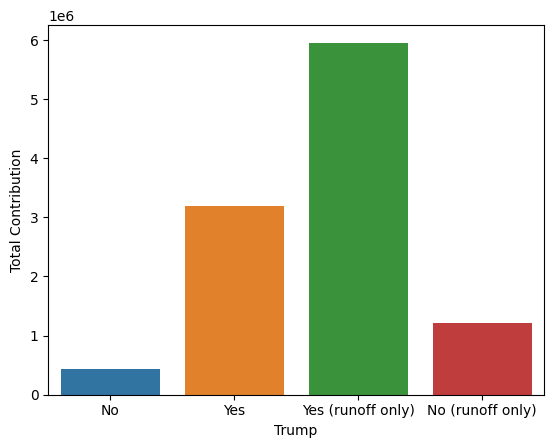

In [19]:
sns.barplot(data=rep_fin_df, x='Trump', y='TTL_INDIV_CONTRIB', errorbar=None)
plt.ylabel('Total Contribution');

On average, candidates with Trump's endorsement have a lot more contribution than those without endorsement. Another notice here is that even though we are missing more than 40 candidates that Trump endorsed (which means that 40 of them are included in "not endorsed" or are missing from this dataset altogether), candidates with Trump endorsement received more than 50% total individuals' contribution. 

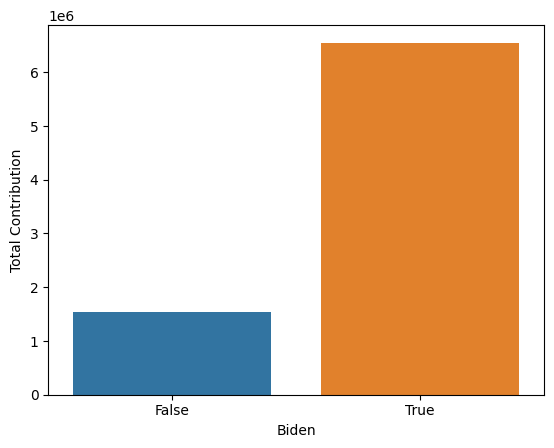

In [20]:
sns.barplot(data=dem_fin_df, x='Biden', y='TTL_INDIV_CONTRIB', errorbar=None)
plt.ylabel('Total Contribution');

Similar to Trump, Biden's endorsement correlated with higher total contributions.

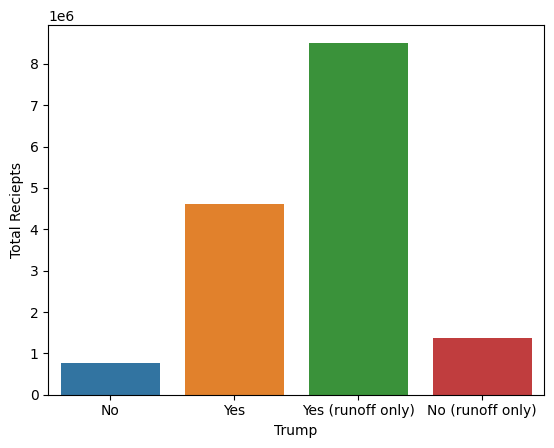

In [21]:
sns.barplot(data=rep_fin_df, x='Trump', y='TTL_RECEIPTS', errorbar=None)
plt.ylabel('Total Reciepts');

Republican candidates that Trump Endorced had much higher amounts of donations than those not endorced

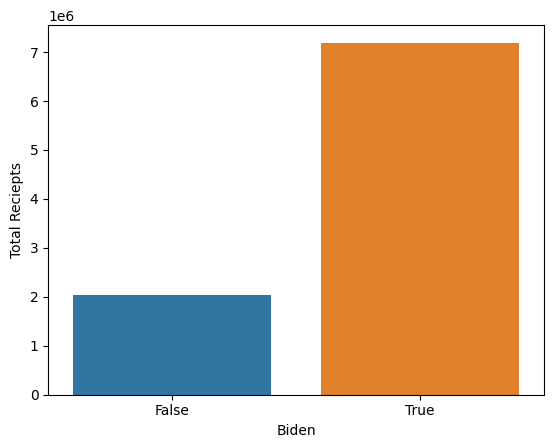

In [22]:
sns.barplot(data=dem_fin_df, x='Biden', y='TTL_RECEIPTS', errorbar=None)
plt.ylabel('Total Reciepts');

Similar to Trump, Biden's endorsement correlated with higher donation.

<AxesSubplot: xlabel='Num Endorcements', ylabel='Primary Votes'>

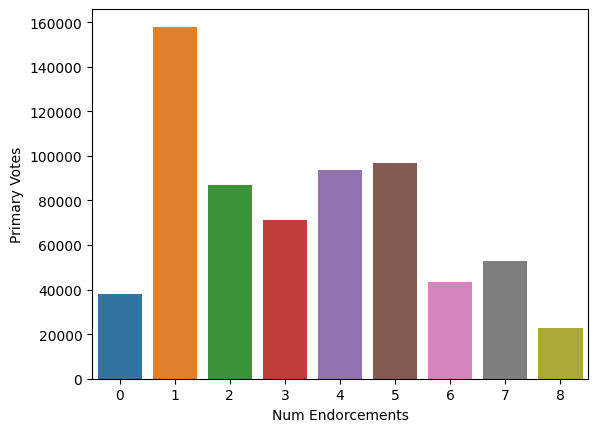

In [23]:
sns.barplot(data=dem_df, x='Num Endorcements', y='Primary Votes', errorbar=None)

It makes sense that the majority of the candidates with higher number of votes would have a small or medium amount of endorsements, because candidates with lots of endorsements might have run on specific enough platforms to get elected.

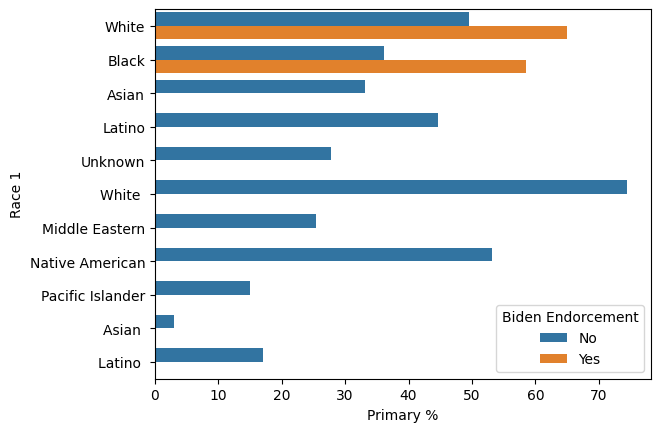

In [24]:
ax = sns.barplot(data=dem_df, x='Primary %', y='Race 1', hue='Biden', errorbar=None)
ax.legend(title="Biden Endorcement", bbox_to_anchor=(1, 0), loc="lower right")
plt.show()

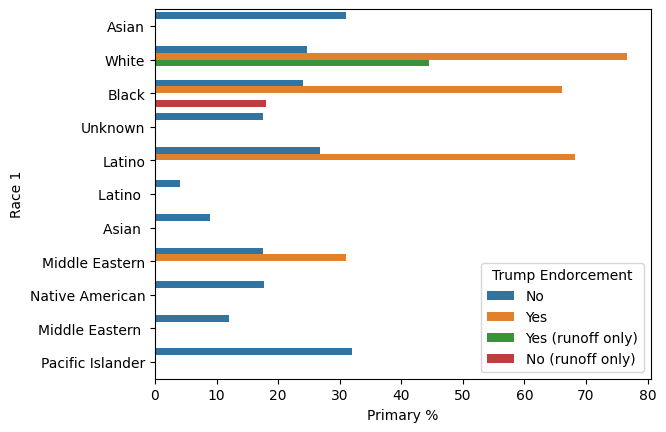

In [25]:
ax = sns.barplot(data=rep_df, x='Primary %', y='Race 1', hue='Trump', errorbar=None)
ax.legend(title="Trump Endorcement", bbox_to_anchor=(1, 0), loc="lower right")
plt.show()

For both White and Black candidates, they performed better on average if they were endorsed by Biden. Trump's endorsements also correlated with White, Black, Latino, and Middle Eastern candidates performing better.

How is this EDA relevant to the goal?

- There is a correlation between endorsement and the outcome of the primary election. We use the average and percent of successes to compare the importance of Trump and Biden's approval for their affiliate party.

- We managed to connect endorsement data and fundraising data, even though Trump has some limitations. However, we believe that it is good enough for data inference because there are still more data points on Trump's side.

# Research question 1:

## Is there any relationship between Democratic politicians/organizations and Trump's endorsement for the success and financing of candidates in the 2022 primary election?

Note that: We treated N/A value in Trump and Biden's columns as No.

https://ballotpedia.org/Endorsements_by_Donald_Trump#Analysis_.282022.29

## Research Q1: Causual Inference using Propensity Score

Load the data. We remove the run off and clean up the finance data.

In [26]:
rep_df = pd.read_csv('rep_finance_2022.csv')
dem_df = pd.read_csv('dem_finance_2022.csv')
rep_df = preprocess_data(rep_df)
dem_df = preprocess_data(dem_df)

#### We will try to calculate propensity score using logistic regression with the treatment as target variable

### Republican

Encode Gender and Primary Outcome as 0, 1. 

In [27]:
Y_col = 'Primary Outcome'
trump = 'Trump'
X = ['TTL_INDIV_CONTRIB', 'TTL_RECEIPTS', 'Incumbent', 'Incumbent Challenger', 'Gender']
categories_var = ['Incumbent', 'Incumbent Challenger', trump]
features = ['TTL_INDIV_CONTRIB', 'TTL_RECEIPTS', 'Incumbent', 'Incumbent Challenger', 'Trump', 'Gender']
rep_ps_df = rep_df[features].copy()


for feature in categories_var:
    rep_ps_df[feature].fillna(0, inplace=True)
    rep_ps_df[feature].replace(to_replace='No', value=0, inplace=True)
    rep_ps_df[feature].replace(to_replace='Yes', value=1, inplace=True)
    rep_ps_df[feature].replace(to_replace='No (runoff only)', value=0, inplace=True)
    rep_ps_df[feature].replace(to_replace='Yes (runoff only)', value=1, inplace=True)

rep_ps_df['Gender'].replace(to_replace='Female', value=0, inplace=True)
rep_ps_df['Gender'].replace(to_replace='Male', value=1, inplace=True)

In [28]:
ps_model = LogisticRegression(C=1e6).fit(rep_ps_df[X], rep_ps_df[trump])
rep_ps_df = rep_ps_df.assign(propensity_score = ps_model.predict_proba(rep_ps_df[X])[:,1])
rep_ps_df = pd.concat([rep_ps_df, rep_df[Y_col]], axis=1)
rep_ps_df.replace(to_replace='Lost', value=0, inplace=True)
rep_ps_df.replace(to_replace='Won', value=1, inplace=True)
rep_ps_df[Y_col] = pd.to_numeric(rep_ps_df[Y_col])
rep_ps_df.head()

,TTL_INDIV_CONTRIB,TTL_RECEIPTS,Incumbent,Incumbent Challenger,Trump,Gender,propensity_score,Primary Outcome
0,11.555248,12.021721,0,0,0,1,0.012921,0
1,13.483697,13.865291,0,0,0,1,0.056981,1
2,10.993691,11.190981,0,0,0,1,0.007420,0
3,10.906616,10.951051,0,1,0,1,0.017349,0
4,9.946308,9.946308,0,1,0,1,0.007906,0


### Inverse propensity score

In [29]:
ipw_estimate = calculate_ipw(rep_ps_df, trump)
ipw_estimate

-2636.7893360624353

The result is too high. So, we remove the extreme values

In [30]:
rep_ps_df = rep_ps_df[(rep_ps_df['propensity_score'] > 0.1) & (rep_ps_df['propensity_score'] < 0.9)]
ipw_estimate = calculate_ipw(rep_ps_df, trump)
ipw_estimate

0.23243513783962402

The Trump endorsement has a negative effect of 0.078 using IPW.

### Democratics

In [31]:
biden = 'Biden'
features = ['TTL_INDIV_CONTRIB', 'TTL_RECEIPTS', 'Incumbent', 'Incumbent Challenger', 'Biden', 'Gender']
dem_ps_df = dem_df[features].copy()
categories_var = ['Incumbent', 'Incumbent Challenger', biden, 'Gender']
dem_ps_df['Gender'].replace(to_replace='Female', value=0, inplace=True)
dem_ps_df['Gender'].replace(to_replace='Male', value=1, inplace=True)

for feature in categories_var:
    dem_ps_df[feature].fillna(0, inplace=True)
    dem_ps_df[feature].replace(to_replace='No', value=0, inplace=True)
    dem_ps_df[feature].replace(to_replace='Yes', value=1, inplace=True)
    dem_ps_df[feature].replace(to_replace='No (runoff only)', value=0, inplace=True)
    dem_ps_df[feature].replace(to_replace='Yes (runoff only)', value=1, inplace=True)

ps_model = LogisticRegression(C=1e6).fit(dem_ps_df[X], dem_ps_df[biden])
dem_ps_df = dem_ps_df.assign(propensity_score = ps_model.predict_proba(dem_ps_df[X])[:,1])
dem_ps_df = pd.concat([dem_ps_df, dem_df[Y_col]], axis=1)
dem_ps_df.replace(to_replace='Lost', value=0, inplace=True)
dem_ps_df.replace(to_replace='Won', value=1, inplace=True)

dem_ps_df.head()

,TTL_INDIV_CONTRIB,TTL_RECEIPTS,Incumbent,Incumbent Challenger,Biden,Gender,propensity_score,Primary Outcome
1,9.121400,9.415238,0,0,False,1,0.007931,0
2,12.282560,12.352306,0,0,False,0,0.047630,1
3,9.045702,9.045702,0,0,False,1,0.006801,0
4,11.919075,13.019453,0,0,False,1,0.040308,1
5,10.577624,12.275070,0,0,False,0,0.041087,0


In [32]:
ipw_estimate = calculate_ipw(dem_ps_df, biden)
ipw_estimate

-94.73375083416553

Let try to remove extreme values to see how it goes

In [33]:
dem_ps_df = dem_ps_df[(dem_ps_df['propensity_score'] > 0.1) & (dem_ps_df['propensity_score'] < 0.9)]
ipw_estimate = calculate_ipw(dem_ps_df, biden)
ipw_estimate

-2.3917353992232355

Joe Biden and other political figures have a negative of -2.25 using propensity score.

In conclusion, both Trump and Joe Biden have negative affect on the success of candidates using propensity score. However, endorsement from Joe Biden is much worse than Trump.

# Random Forest

Since we don't have much data, using random forest is a better choice than deep learning

## Republican

For republican candidates, we will use features: 

- Categorical : 'Gender', 'Incumbent', 'Incumbent Challenger', 'Trump','Club for Growth', 'Party Committee', 'Renew America', 'E-PAC', 'VIEW PAC', 'Maggie's List', 'Winning for Women'

- 'TTL_RECEIPTS', 'TTL_INDIV_CONTRIB': numerical variables

In [34]:
categorical_variables = ['Gender', 'Incumbent', 'Incumbent Challenger', 'Trump','Club for Growth', 'Party Committee',
       'Renew America', 'E-PAC', 'VIEW PAC', 'Maggie\'s List', 'Winning for Women']
Y_col = 'Primary Outcome'
money = ['TTL_RECEIPTS', 'TTL_INDIV_CONTRIB']

def preprocess(df):
    """
    Do some encoding for binary variable
    """
    df['Gender'].replace(to_replace='Male', value=1, inplace=True)
    df['Gender'].replace(to_replace='Female', value=0, inplace=True)

    df['Incumbent'].replace(to_replace='No', value=0, inplace=True)
    df['Incumbent'].replace(to_replace='Yes', value=1, inplace=True)

    df['Incumbent Challenger'].replace(to_replace='Yes', value=1, inplace=True)
    df['Incumbent Challenger'].replace(to_replace='No', value=0, inplace=True)


    df[Y_col].replace(to_replace='Won', value=1, inplace=True)
    df[Y_col].replace(to_replace='Lost', value=0, inplace=True)

    # Money
    for m in money:
        df[m] = np.log1p(df[m])
    return df

rep_df = preprocess(rep_df)
dem_df = preprocess(dem_df)   

endorser_list = ['Trump','Club for Growth', 'Party Committee', 'Renew America', 'E-PAC', 'VIEW PAC', 'Maggie\'s List', 'Winning for Women']
for endorser in endorser_list:
    rep_df[endorser].fillna(0, inplace=True)
    rep_df[endorser].replace(to_replace='No', value=0, inplace=True)
    rep_df[endorser].replace(to_replace='Yes', value=1, inplace=True)
    rep_df[endorser].replace(to_replace='No (runoff only)', value=0, inplace=True)
    rep_df[endorser].replace(to_replace='Yes (runoff only)', value=1, inplace=True)

X_cols = categorical_variables
X_cols.extend(money)

In [35]:
temp = X_cols.copy()
temp.append(Y_col)
rep_df = rep_df[temp].dropna()

Create random forest model and fit data

In [36]:
rf = RandomForestClassifier()
train, test = train_test_split(rep_df, random_state=42, stratify=rep_df[Y_col])

rf.fit(train[X_cols], train[Y_col])

RandomForestClassifier()

Get the accuracy

In [37]:
rf.score(test[X_cols], test[Y_col])

0.8151658767772512

In [38]:
# Define the parameter grid
def get_best_hyperparams_rf():
    param_grid = {
        'n_estimators': [100, 200, 300, 400, 500],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4, 8],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False],
        'class_weight': [None, 'balanced']
    }


    # Create the grid search object
    grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')

    # Perform grid search on the training data
    grid_search.fit(train[X_cols], train[Y_col])

    # Print the best parameters and best score
    print("Best parameters: ", grid_search.best_params_)
    print("Best score: ", grid_search.best_score_)

 ## Democratic

Feature engineering data for democratic party

In [39]:
dem_endorser = ['EMILY\'s List', 'PCCC', 'Our Revolution', 'Sunrise', 'Party Committee', 'Biden']
dem_features = dem_endorser
dem_features.extend(money)

for endorser in dem_endorser:
    dem_df[endorser].fillna(0, inplace=True)
    dem_df[endorser].replace(to_replace='No', value=0, inplace=True)
    dem_df[endorser].replace(to_replace='Yes', value=1, inplace=True)
    dem_df[endorser].replace(to_replace='No (runoff only)', value=0, inplace=True)
    dem_df[endorser].replace(to_replace='Yes (runoff only)', value=1, inplace=True)

dem_features.extend(['Gender', 'Incumbent', 'Incumbent Challenger'])

In [40]:
temp = dem_features.copy()
temp.append(Y_col)
dem_df = dem_df[temp].dropna()
dem_df['Biden'] = dem_df['Biden'].astype(int)

Train the model and calculate the accuracy

In [41]:
dem_train, dem_test = train_test_split(dem_df, random_state=42, stratify=dem_df[Y_col])
dem_rf = RandomForestClassifier()
dem_rf.fit(dem_train[dem_features], dem_train[Y_col])
dem_rf.score(dem_test[dem_features], dem_test[Y_col])

0.756578947368421

### GLM

Next we will use GLM model for predicting primary outcomes.

#### Frequentist

##### Republicans

Since we predict 0 and 1, we use the Binomal family.

In [42]:
freq_model = sm.GLM(train[Y_col], exog=sm.add_constant(train[X_cols]), family=sm.families.Binomial())
freq_res = freq_model.fit()
print(freq_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        Primary Outcome   No. Observations:                  632
Model:                            GLM   Df Residuals:                      618
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -232.97
Date:                Tue, 09 May 2023   Deviance:                       465.95
Time:                        01:03:23   Pearson chi2:                     487.
No. Iterations:                    22   Pseudo R-squ. (CS):             0.4406
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -8.7507 

In [43]:
glm_y_predict = (freq_res.predict(sm.add_constant(test[X_cols])) > 0.5).astype(int)
print_confusion_matrix(test[Y_col], glm_y_predict)

True positive 39
True negative 131
False negative 39
False positive 2


(39, 131, 39, 2)

##### Democratics

In [44]:
dem_freq_model = sm.GLM(dem_train[Y_col], exog=sm.add_constant(dem_train[dem_features]), family=sm.families.Binomial())
dem_freq_res = dem_freq_model.fit()
print(dem_freq_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        Primary Outcome   No. Observations:                  453
Model:                            GLM   Df Residuals:                      441
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -180.98
Date:                Tue, 09 May 2023   Deviance:                       361.95
Time:                        01:03:24   Pearson chi2:                     872.
No. Iterations:                    21   Pseudo R-squ. (CS):             0.4412
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -4.8204 

In [45]:
glm_y_predict = (dem_freq_res.predict(sm.add_constant(dem_test[dem_features])) > 0.55).astype(int)
print_confusion_matrix(dem_test[Y_col], glm_y_predict)

True positive 44
True negative 67
False negative 38
False positive 3


(44, 67, 38, 3)

### Bayesian GLM

We will use logistic regression for Bayesian GLM. The linear model is a combination of Beta distribution (for binary variables) and Normal Distribution (for funding).

For Republican:

Define the model and get its trace.

In [46]:
with pm.Model() as beyesian_model:
    # priors
    genders = pm.Beta('Gender', alpha=2, beta=1)
    incumbent = pm.Beta('Incumbent', alpha=3, beta=2)
    incumbent_challenger = pm.Beta('Incumbent Challenger', alpha=2, beta=5)
    total_receipt = pm.Normal('TTL_RECEIPTS', mu=11, sigma=5)
    indi_receipt = pm.Normal('TTL_INDIV_CONTRIB', mu=11, sigma=5)
    trump_endorse = pm.Beta('Trump', alpha=3, beta=2)
    party_endorse = pm.Beta('Party Committee', alpha=3, beta=2)
    renew_endorse = pm.Beta('Renew America', alpha=3, beta=2)
    epac_endorse = pm.Beta('E-PAC', alpha=3, beta=2)
    view_endorse = pm.Beta('VIEW PAC', alpha=3, beta=2)
    maggie_endorse = pm.Beta('Maggie\'s List', alpha=3, beta=2)
    women_endorse = pm.Beta('Winning for Women', alpha=3, beta=2)
    club_endorse = pm.Beta('Club for Growth', alpha=3, beta=2)

    intercept = pm.Normal('intercept', mu=0, sigma=10)
    # likelihood function
    likelihood = pm.math.sigmoid(train['Gender'].values * genders + train['Incumbent'].values * incumbent \
                + train['Incumbent Challenger'].values * incumbent_challenger \
                + total_receipt * train['TTL_RECEIPTS'].values + indi_receipt * train['TTL_INDIV_CONTRIB'].values \
                + trump_endorse * train['Trump'].values + party_endorse * train['Party Committee'].values \
                + renew_endorse * train['Renew America'].values + epac_endorse * train['E-PAC'].values \
                + view_endorse * train['VIEW PAC'].values + maggie_endorse * train['Maggie\'s List'].values \
                + club_endorse * train['Club for Growth'] \
                + women_endorse * train['Winning for Women'].values + intercept)

    Y_obs = pm.Bernoulli("Y_obs", p=likelihood, observed=train[Y_col])
    trace = pm.sample()
    post_predictive = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Gender, Incumbent, Incumbent Challenger, TTL_RECEIPTS, TTL_INDIV_CONTRIB, Trump, Party Committee, Renew America, E-PAC, VIEW PAC, Maggie's List, Winning for Women, Club for Growth, intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 189 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [Y_obs]


In [47]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
TTL_RECEIPTS,4.100,1.066,2.105,6.092,0.031,0.022,1186.0,1267.0,1.00
TTL_INDIV_CONTRIB,0.881,0.711,-0.345,2.260,0.019,0.016,1590.0,1353.0,1.00
intercept,-14.051,1.820,-17.351,-10.560,0.046,0.033,1540.0,1600.0,1.00
Gender,0.459,0.199,0.086,0.816,0.005,0.004,1558.0,1128.0,1.00
Incumbent,0.889,0.076,0.752,0.996,0.002,0.001,1874.0,994.0,1.00
Incumbent Challenger,0.074,0.049,0.002,0.161,0.001,0.001,2551.0,1122.0,1.00
Trump,0.857,0.092,0.695,0.992,0.002,0.001,1757.0,1068.0,1.00
Party Committee,0.731,0.164,0.439,0.991,0.003,0.002,2351.0,1238.0,1.00
Renew America,0.538,0.202,0.197,0.917,0.004,0.003,2576.0,1580.0,1.00
E-PAC,0.595,0.202,0.221,0.938,0.004,0.003,2883.0,1256.0,1.00


In [48]:
threshold = 0.56
coeffs = list(trace.posterior[X_cols].mean()[X_cols].values())
coeffs = [coeffs[i].values.item() for i in range(len(X_cols))]
y_pre_proba = sigmoid(np.dot(test[X_cols], coeffs) + trace.posterior['intercept'].mean().values.item(0))
y_pre_beyesian_decision = (y_pre_proba > threshold).astype(int)
tp, tn, fp, fn = print_confusion_matrix(test[Y_col], y_pre_beyesian_decision)
bayesian_accuracy = get_accuracy(tp, tn, fp, fn)
bayesian_accuracy

True positive 40
True negative 130
False negative 38
False positive 3


0.8056872037914692

Used to find the optimal threshold, commented out since it is not needed any more.

In [49]:
#optimal_threshold_rep, optimal_accuracy_rep = find_optimal_threshold(trace, X_cols, Y_col)
#print("Optimal Threshold:", optimal_threshold_rep)
#print("Optimal Accuracy:", optimal_accuracy_rep)

Optimal Threshold: 0.56,
Optimal Accuracy: 0.8514851485148515

True positive 52,
True negative 121,
False negative 25,
False positive 4

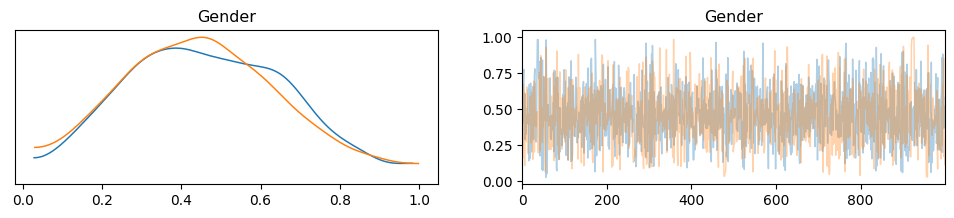

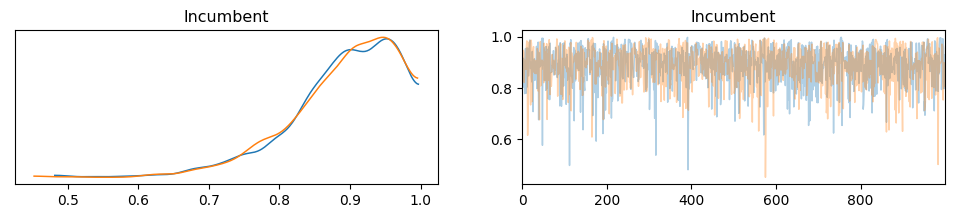

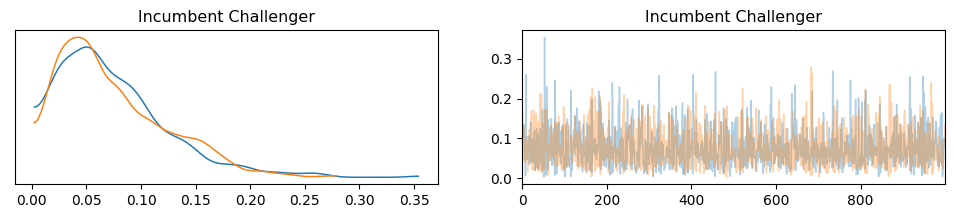

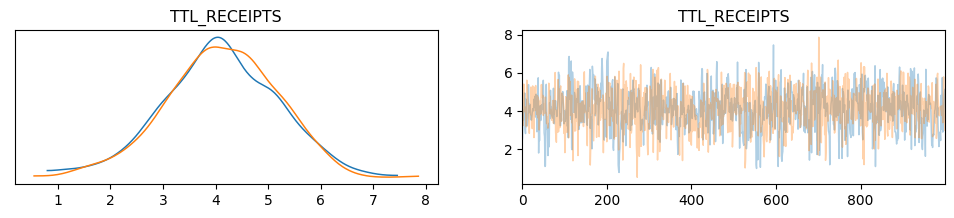

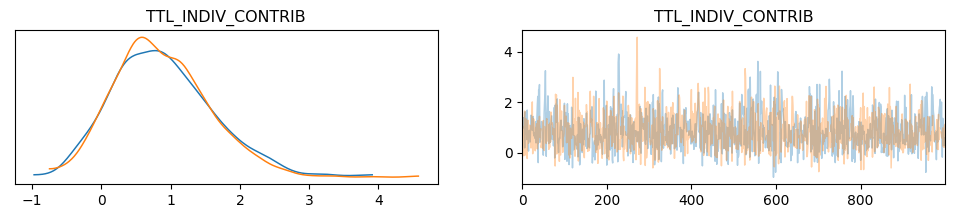

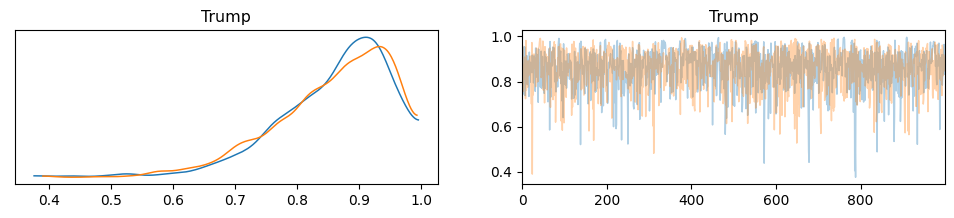

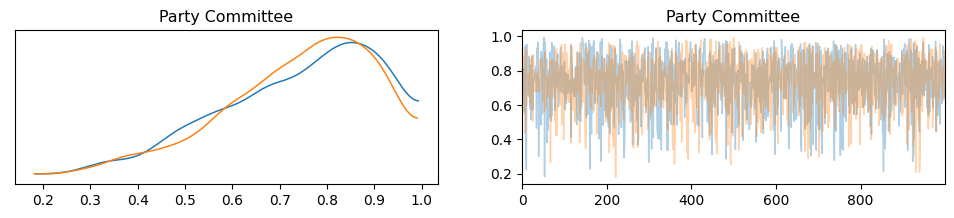

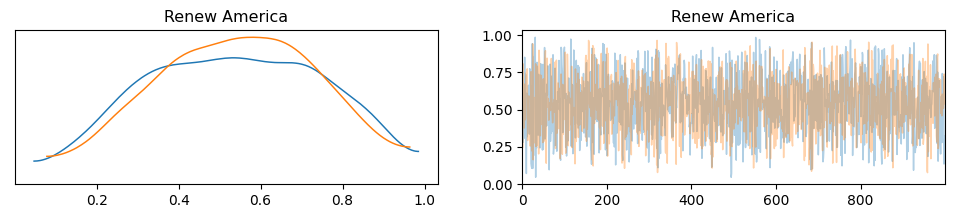

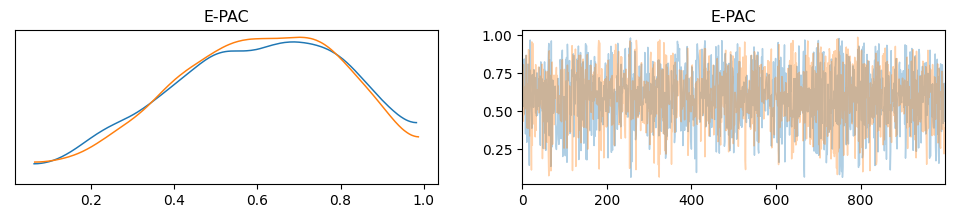

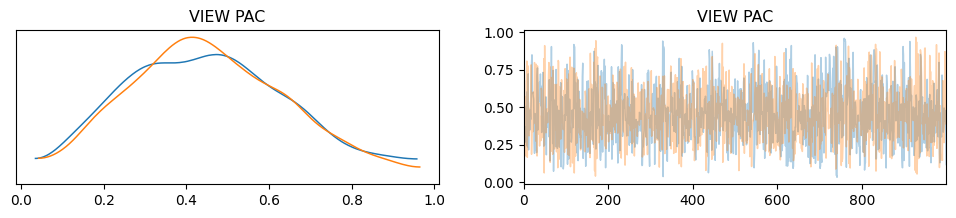

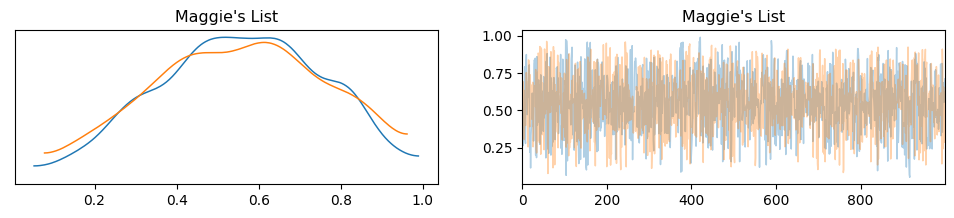

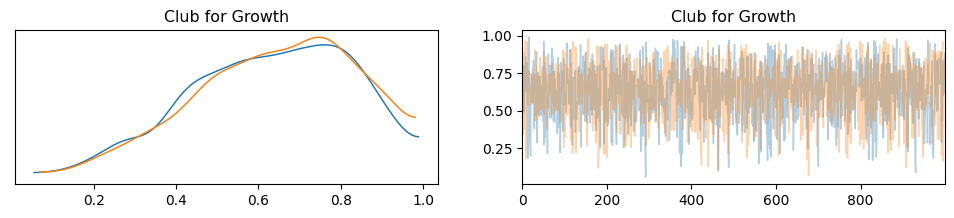

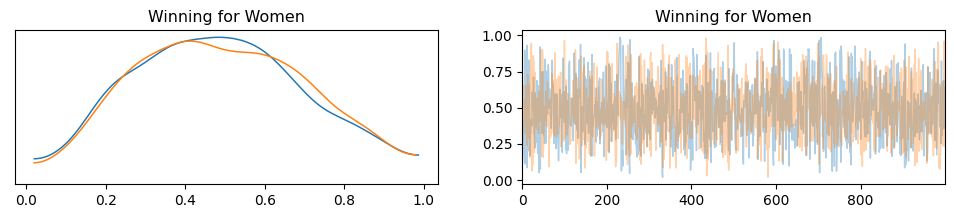

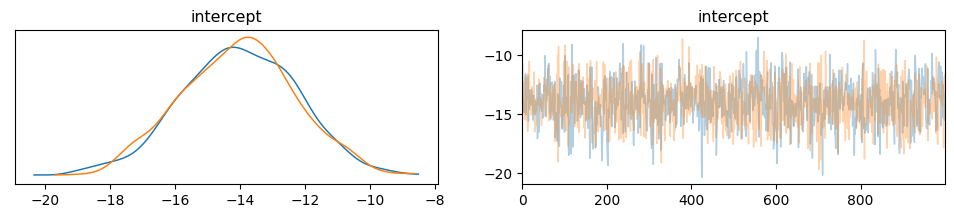

In [50]:
# az.plot_trace(trace, compact=False);
var_names = ['Gender', 'Incumbent', 'Incumbent Challenger', 'TTL_RECEIPTS', 'TTL_INDIV_CONTRIB',
             'Trump', 'Party Committee', 'Renew America', 'E-PAC', 'VIEW PAC',
             'Maggie\'s List', 'Club for Growth', 'Winning for Women', 'intercept']
             
with pm.Model() as model:
    for var_name in var_names:
        az.plot_trace(trace, var_name, compact=False);

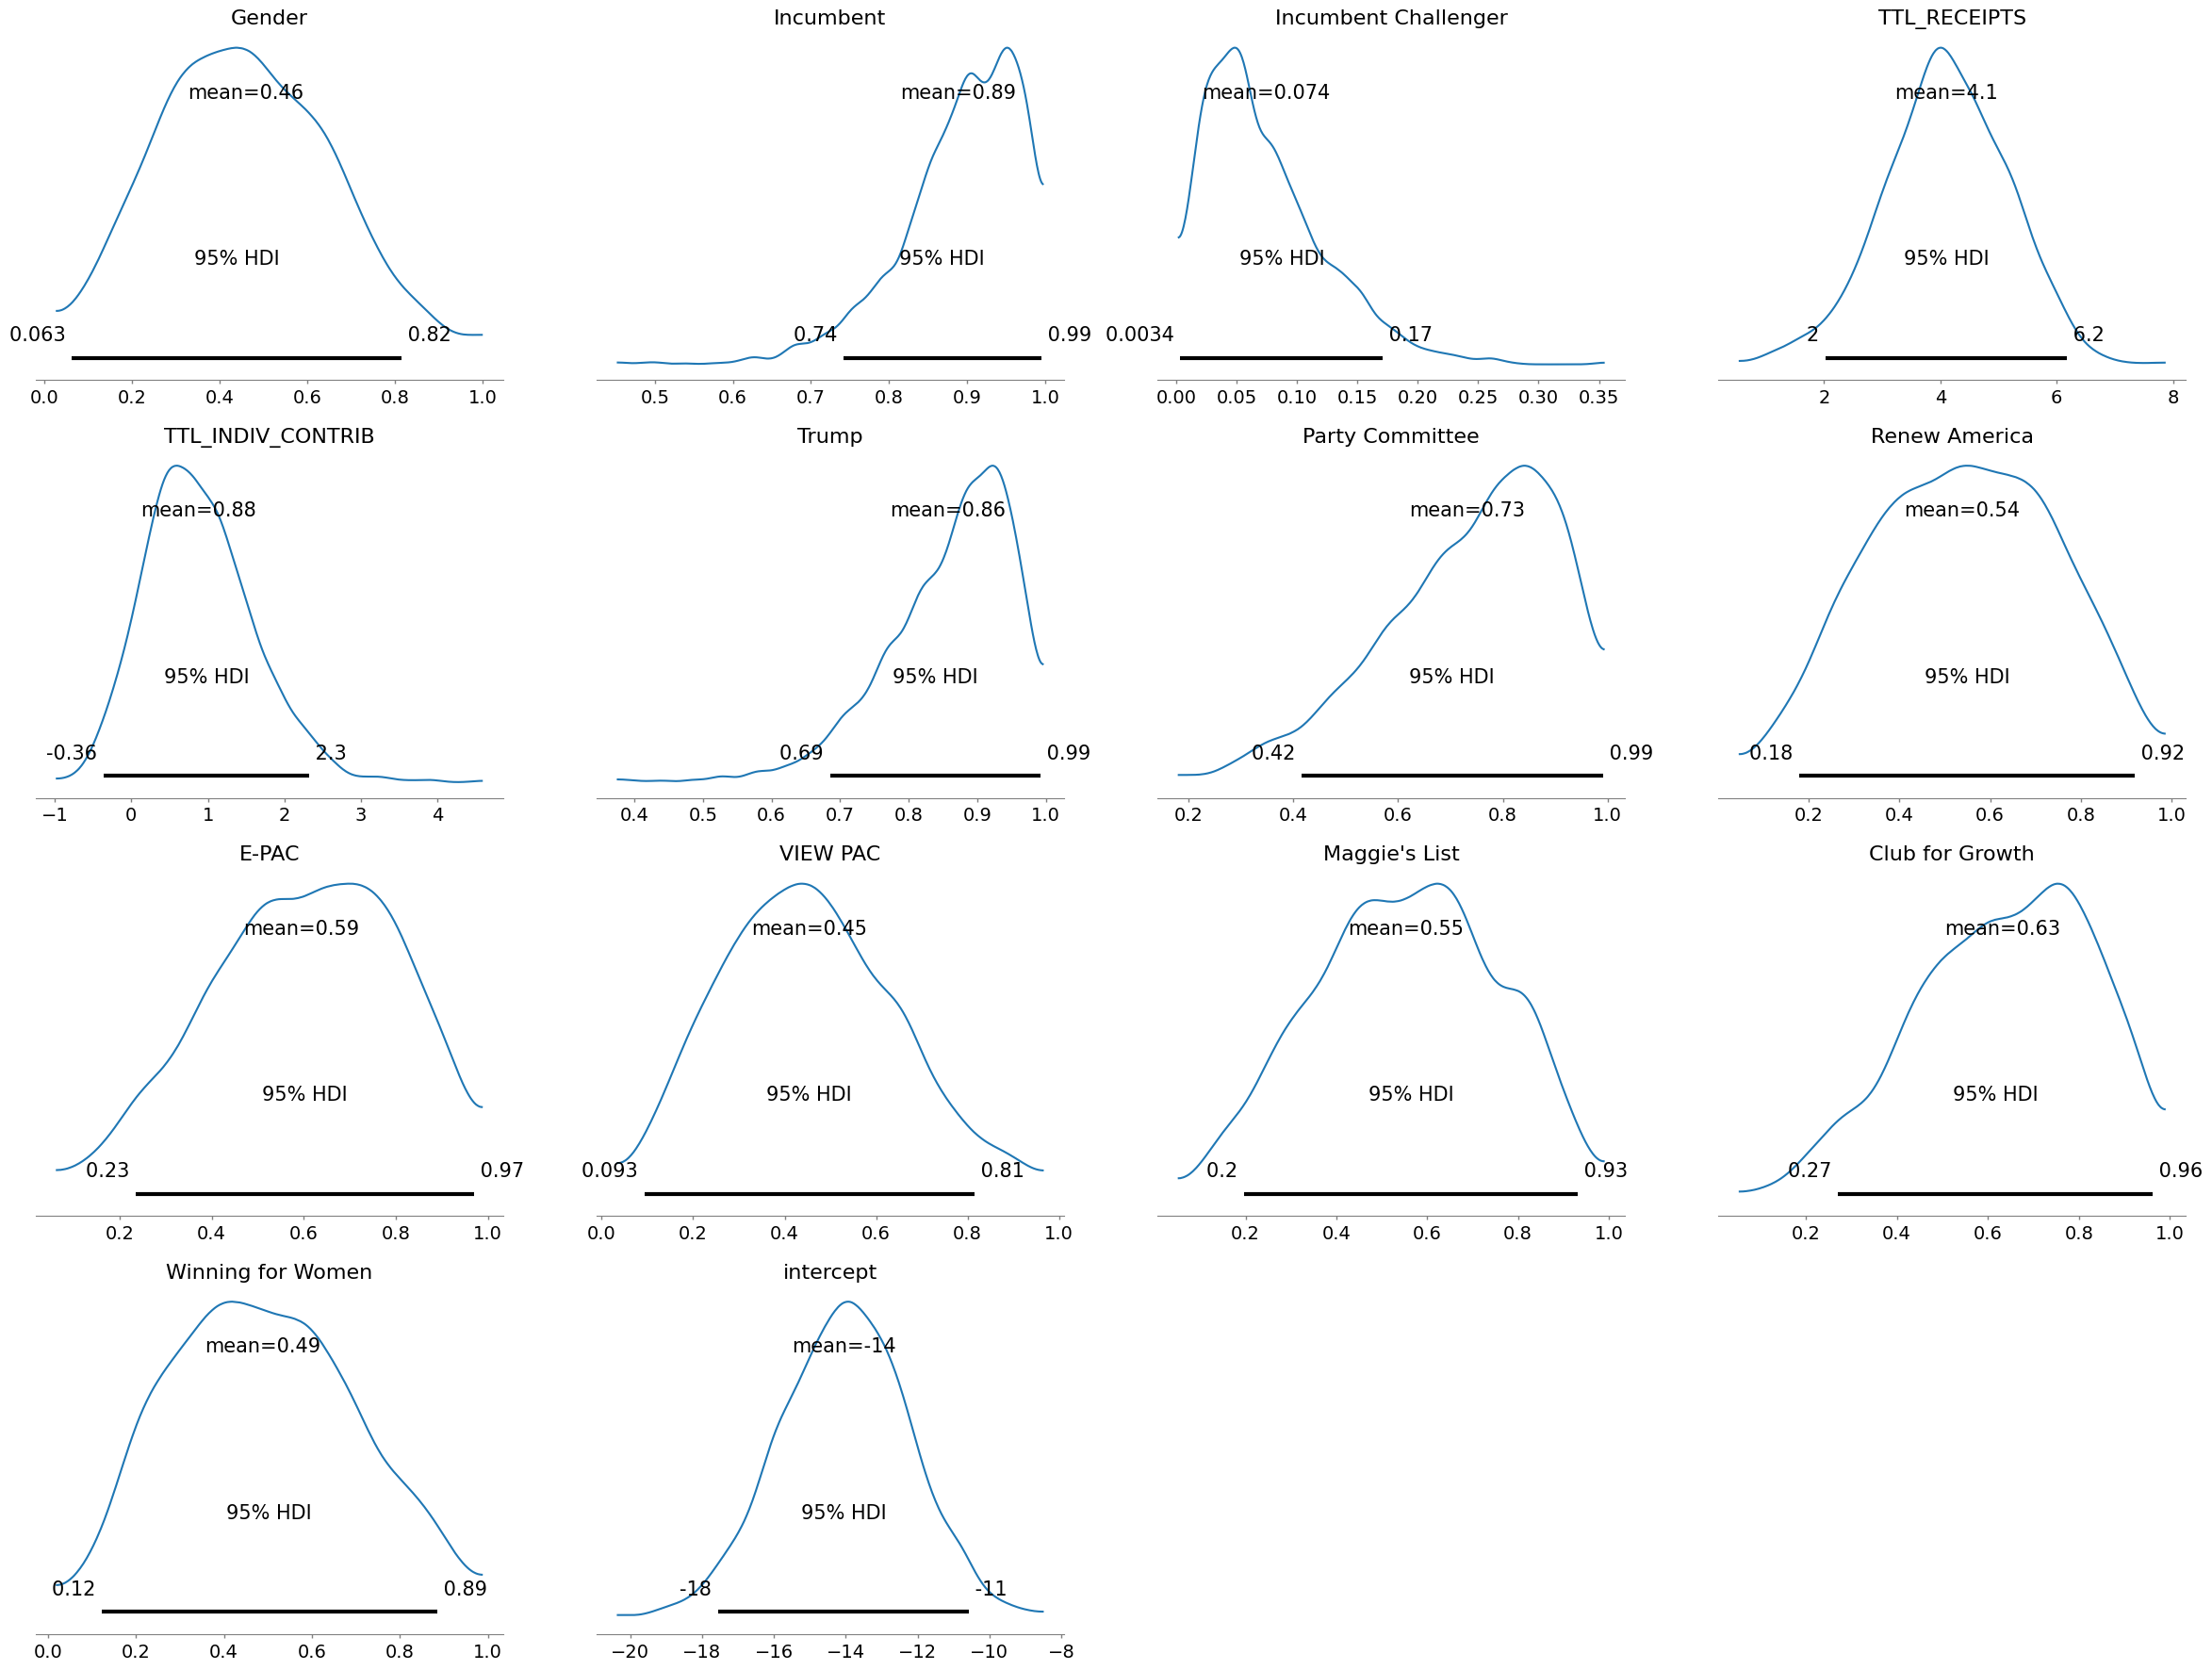

In [51]:
az.plot_posterior(trace, var_names=var_names, hdi_prob=0.95);

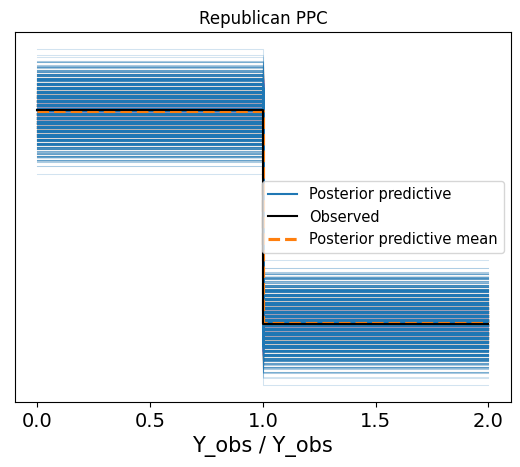

In [52]:
az.plot_ppc(post_predictive)
plt.title('Republican PPC');

##### Democratic

Define the model and get its trace.

In [53]:
with pm.Model() as dem_beyesian_model:
    # priors
    genders = pm.Beta('Gender', alpha=2, beta=1)
    incumbent = pm.Beta('Incumbent', alpha=3, beta=2)
    incumbent_challenger = pm.Beta('Incumbent Challenger', alpha=2, beta=5)
    total_receipt = pm.Normal('TTL_RECEIPTS', mu=11, sigma=5)
    indi_receipt = pm.Normal('TTL_INDIV_CONTRIB', mu=11, sigma=5)
    biden_endorse = pm.Beta('Biden', alpha=3, beta=2)
    party_endorse = pm.Beta('Party Committee', alpha=3, beta=2)
    pccc_endorse = pm.Beta('PCCC', alpha=3, beta=2)
    revolution_endorse = pm.Beta('Our Revolution', alpha=3, beta=2)
    sunrise_endorse = pm.Beta('Sunrise', alpha=3, beta=2)
    emily_endorse = pm.Beta('EMILY\'s List', alpha=3, beta=2)

    intercept = pm.Normal('intercept', mu=0, sigma=10)
    # likelihood function
    likelihood = pm.math.sigmoid(dem_train['Gender'].values * genders + dem_train['Incumbent'].values * incumbent \
                + dem_train['Incumbent Challenger'].values * incumbent_challenger \
                + total_receipt * dem_train['TTL_RECEIPTS'].values + indi_receipt * dem_train['TTL_INDIV_CONTRIB'].values \
                + biden_endorse * dem_train['Biden'].values + party_endorse * dem_train['Party Committee'].values \
                + pccc_endorse * dem_train['PCCC'].values + revolution_endorse * dem_train['Our Revolution'].values \
                + sunrise_endorse * dem_train['Sunrise'].values + emily_endorse * dem_train['EMILY\'s List'].values )

    Y_obs = pm.Bernoulli("Y_obs", p=likelihood, observed=dem_train[Y_col])
    dem_trace = pm.sample()
    dem_post_predictive = pm.sample_posterior_predictive(dem_trace)

az.summary(dem_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Gender, Incumbent, Incumbent Challenger, TTL_RECEIPTS, TTL_INDIV_CONTRIB, Biden, Party Committee, PCCC, Our Revolution, Sunrise, EMILY's List, intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 126 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [Y_obs]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
TTL_RECEIPTS,-2.098,0.802,-3.783,-0.849,0.027,0.021,1013.0,877.0,1.00
TTL_INDIV_CONTRIB,2.037,0.814,0.648,3.630,0.027,0.021,1012.0,899.0,1.00
intercept,-0.024,9.684,-18.472,16.723,0.223,0.229,1899.0,1391.0,1.00
Gender,0.204,0.114,0.013,0.403,0.003,0.002,1757.0,1057.0,1.00
Incumbent,0.939,0.043,0.856,1.000,0.001,0.001,1687.0,718.0,1.00
Incumbent Challenger,0.062,0.044,0.001,0.139,0.001,0.001,1425.0,754.0,1.00
Biden,0.526,0.194,0.196,0.899,0.004,0.003,2053.0,1414.0,1.01
Party Committee,0.719,0.166,0.424,0.984,0.004,0.003,1543.0,1131.0,1.00
PCCC,0.457,0.196,0.087,0.790,0.005,0.004,1567.0,970.0,1.00
Our Revolution,0.526,0.196,0.179,0.884,0.004,0.003,1930.0,1337.0,1.00


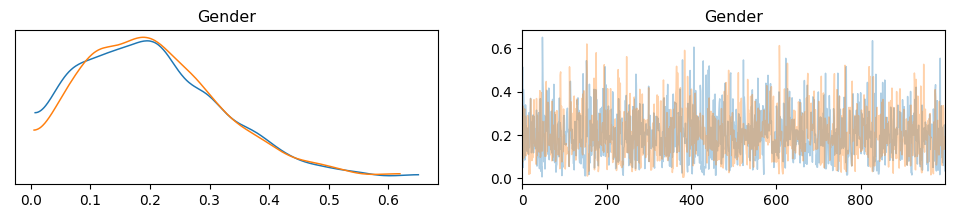

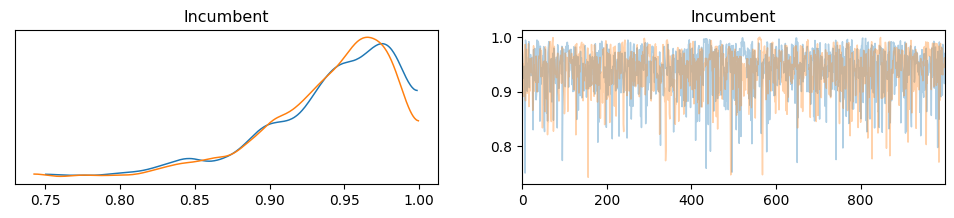

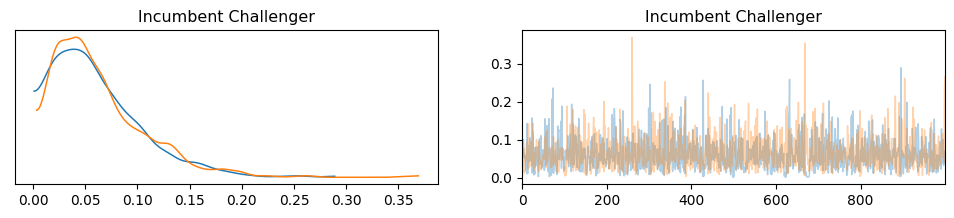

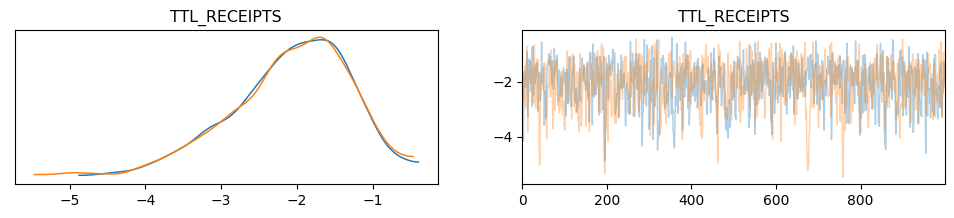

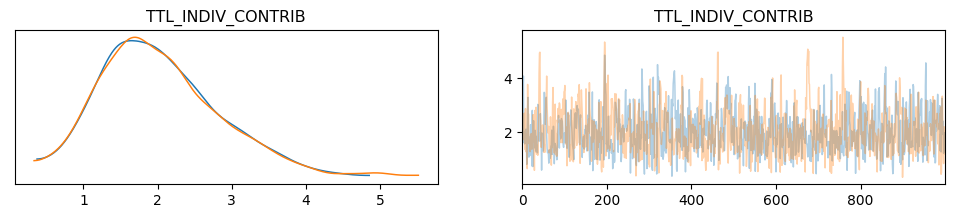

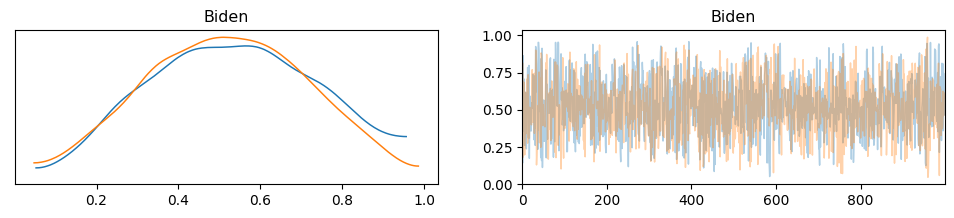

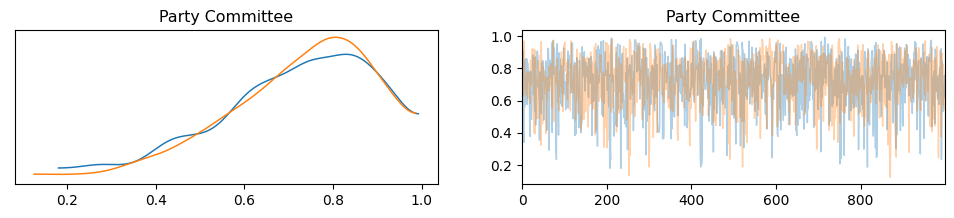

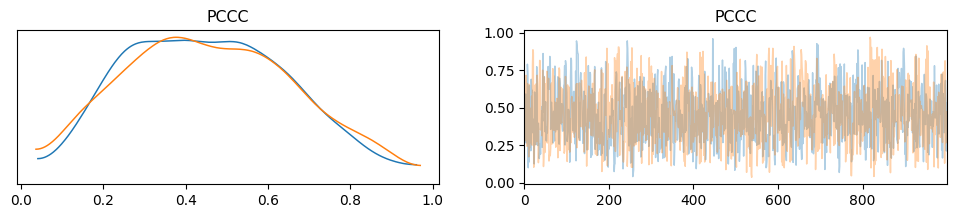

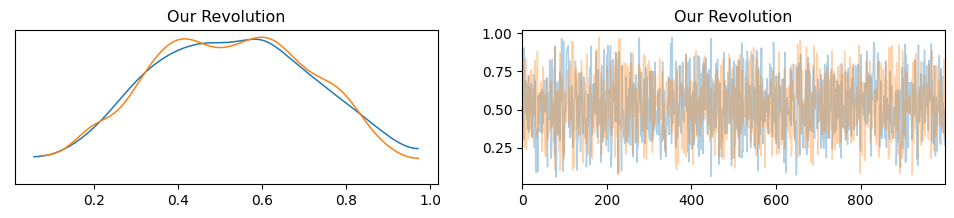

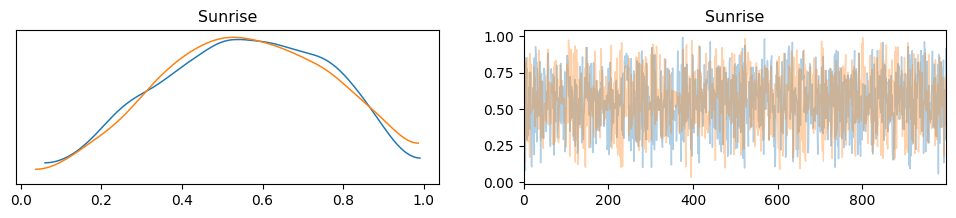

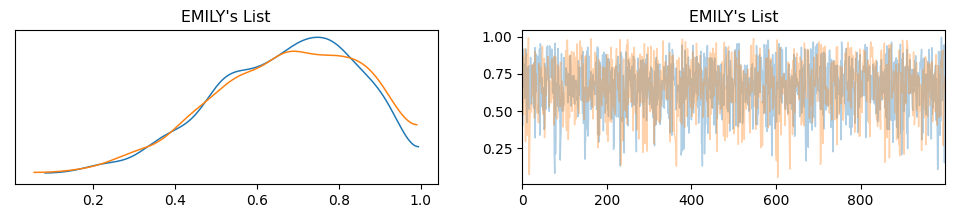

In [54]:
var_names = ['Gender', 'Incumbent', 'Incumbent Challenger', 'TTL_RECEIPTS', 'TTL_INDIV_CONTRIB', 
        'Biden', 'Party Committee', 'PCCC', 'Our Revolution', 'Sunrise', "EMILY's List"]


with pm.Model() as model:
    for var_name in var_names:
        az.plot_trace(dem_trace, var_name, compact=False);

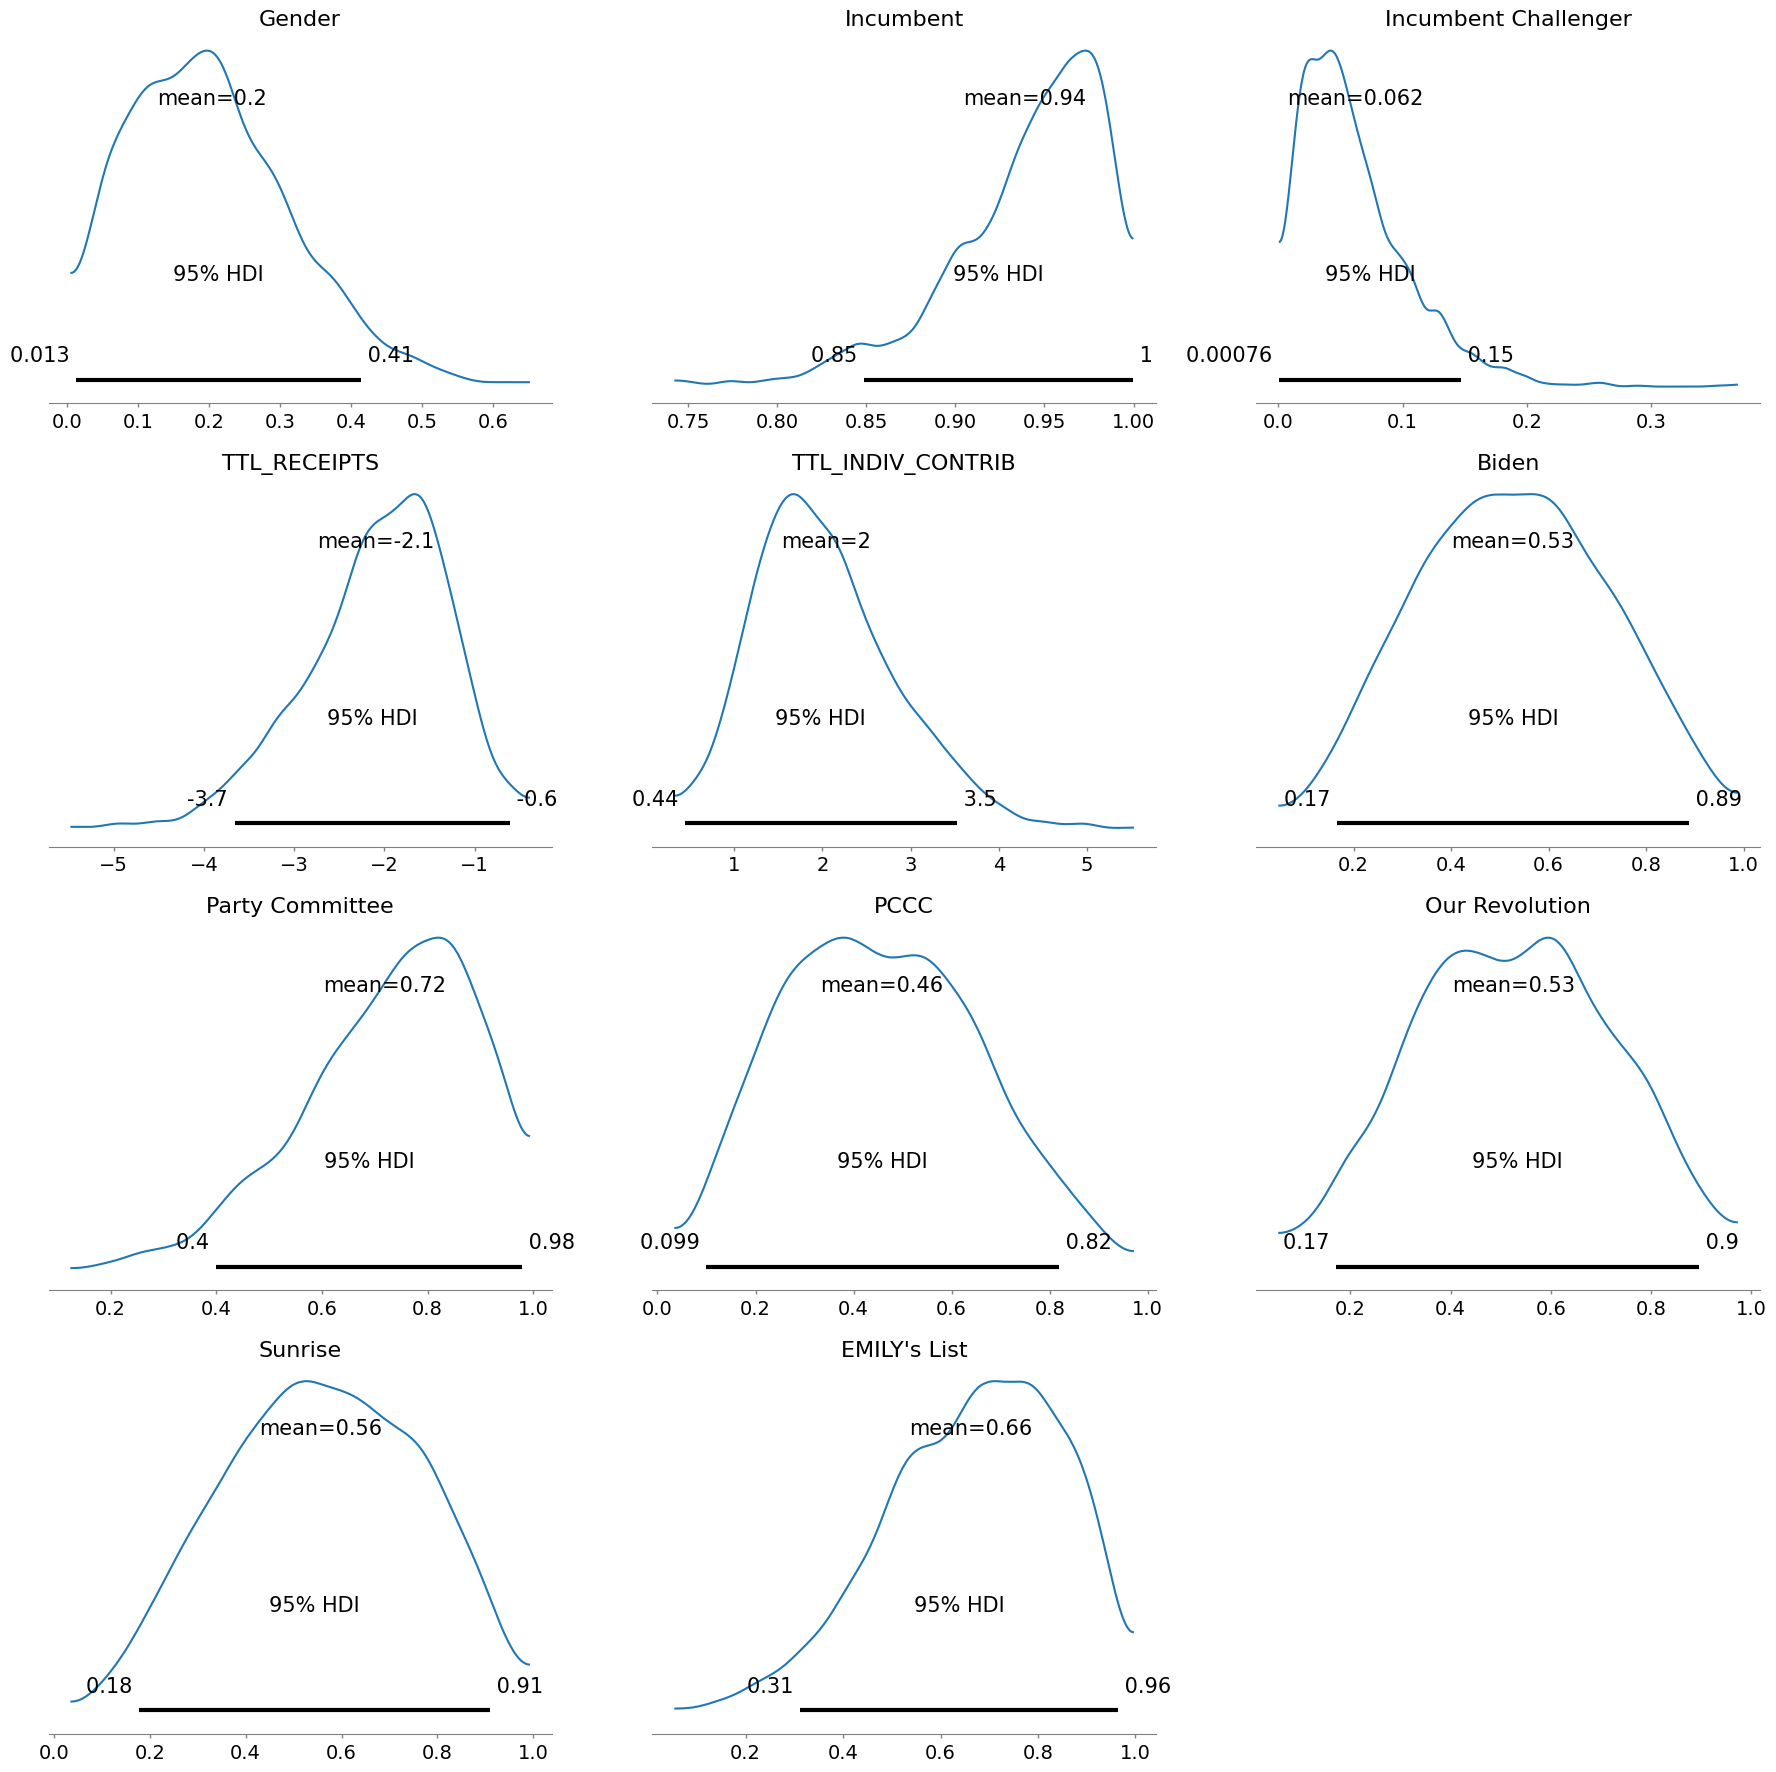

In [55]:
az.plot_posterior(dem_trace, var_names=var_names, hdi_prob=0.95); # graph credible interval

Used to find the optimal threshold, commented out since it is not needed any more.

In [56]:
#threshold_range = (0, 1)  # Adjust the range as desired
#optimal_threshold_dem, optimal_accuracy_dem = find_optimal_threshold(dem_trace, dem_features, Y_col, dem_test, threshold_range)
#print("Optimal Threshold:", optimal_threshold_dem)
#print("Optimal Accuracy:", optimal_accuracy_dem)


Optimal Threshold: 0.58, 
Optimal Accuracy: 0.7297297297297297

In [57]:
threshold = 0.58
coeffs = list(dem_trace.posterior[dem_features].mean()[dem_features].values())
coeffs = [coeffs[i].values.item() for i in range(len(dem_features))]
y_pre_proba = sigmoid(np.dot(dem_test[dem_features], coeffs) + dem_trace.posterior['intercept'].mean().values.item(0))
y_pre_beyesian_decision = (y_pre_proba > threshold).astype(int)
tp2, tn2, fp2, fn2 = print_confusion_matrix(dem_test[Y_col], y_pre_beyesian_decision)

True positive 46
True negative 64
False negative 36
False positive 6


In [58]:
bayesian_accuracy = get_accuracy(tp2, tn2, fp2, fn2)
bayesian_accuracy

0.7236842105263158

It performed a bit better than expected.

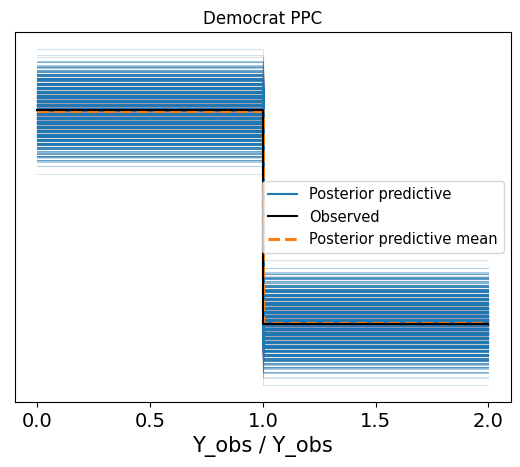

In [59]:
az.plot_ppc(post_predictive)
plt.title('Democrat PPC');

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=216a7fe2-90ea-465b-872a-bc33d2f4ca6a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>